# Figure Generation for the Ribo-Seq Data Portal Manuscript

We want a multi panel figure that shows a breakdown of the contents of the metadata stored in the RDP database. 

The areas we want to get a breakdown of include:
- Organism
- Inhibitor 
- Cell Lines/Tissues 
- Missing Data 

In [822]:
# !pip install pandas plotly nbformat

In [823]:
import pandas as pd
from textwrap import wrap
import plotly.graph_objects as go

df = pd.read_csv('standardized_columns_final_2023-12-18.csv')

/tmp/ipykernel_1969995/1022401026.py:5: DtypeWarning:

Columns (32,33,34,40,41,42,63,73,74,78,79,83) have mixed types. Specify dtype option on import or set low_memory=False.



In [824]:
len(df['ScientificName'].unique())

107

In [825]:
def plot_organism_metadata_pie(df):
    df_organism_counts = df.groupby('ScientificName').size().reset_index(name='counts')
    df_organism_counts.sort_values('counts', ascending=False, inplace=True)
    accepted_organisms = df_organism_counts['ScientificName'].head(12).tolist()
    df_organism_counts['ScientificName_Other'] = df_organism_counts['ScientificName'].apply(lambda x: x if x in accepted_organisms else 'Other Organisms')
    fig = px.pie(df_organism_counts, names='ScientificName_Other', values='counts', title='Organism Breakdown')
    fig.show()

plot_organism_metadata_pie(df)

In [826]:
def plot_organism_metadata_bar(df, subset=5):
    df_organism_counts = df.groupby('ScientificName').size().reset_index(name='counts')
    df_organism_counts.sort_values('counts', ascending=False, inplace=True)
    accepted_organisms = df_organism_counts['ScientificName'].head(subset).tolist()
    df_organism_counts['ScientificName_Other'] = df_organism_counts['ScientificName'].apply(lambda x: x if x in accepted_organisms else 'Other Organisms')
    
    # Create a go.Bar object
    bar_trace = go.Bar(
        x=df_organism_counts['counts'],
        y=df_organism_counts['ScientificName_Other'],
        orientation='h',
        name='Organism Breakdown'
    )
        
    return bar_trace
# plot_organism_metadata_bar(df)

In [827]:
import plotly.express as px

def plot_organism_metadata_lollipop(df):
    df_organism_counts = df.groupby('ScientificName').size().reset_index(name='counts')
    df_organism_counts.sort_values('counts', ascending=False, inplace=True)
    accepted_organisms = df_organism_counts['ScientificName'].head(12).tolist()
    df_organism_counts['ScientificName_Other'] = df_organism_counts['ScientificName'].apply(lambda x: x if x in accepted_organisms else 'Other Organisms')
    
    # Create a lollipop chart
    fig = px.scatter(df_organism_counts, x='counts', y='ScientificName_Other', orientation='h', text='counts')
    
    # Customize the chart appearance
    fig.update_traces(mode='markers', marker=dict(size=10, color='red'))
    fig.update_layout(
        xaxis_title="Number of Entries",
        yaxis_title="Organism",
        yaxis_categoryorder='total descending',  # Sort categories by count in descending order
        showlegend=False
    )
    
    return fig

plot_organism_metadata_lollipop(df)

In [828]:

import plotly.colors as colors

def plot_organism_metadata_stacked(df):
    df_organism_counts = df.groupby('ScientificName').size().reset_index(name='counts')
    df_organism_counts.sort_values('counts', ascending=False, inplace=True)
    accepted_organisms = df_organism_counts['ScientificName'].head(12).tolist()
    df_organism_counts['ScientificName_Other'] = df_organism_counts['ScientificName'].apply(lambda x: x if x in accepted_organisms else 'Other Organisms')
    
    # Create a horizontal stacked bar chart
    fig = px.bar(df_organism_counts, x='counts', y='ScientificName_Other', orientation='h', color='ScientificName_Other')

    # Customize the chart appearance
    fig.update_layout(
        xaxis_title="Number of Entries",
        yaxis_title="Organism",
        yaxis_categoryorder='total descending',  # Sort categories by count in descending order
        barmode='stack',
        legend_title_text='Organism'
    )
    
    return fig
plot_organism_metadata_stacked(df)

In [829]:
def plot_inhibitor(df):
    df['INHIBITOR_Updated'] = df['INHIBITOR_st'].replace(
        {
            'chx': 'Cycloheximide',
            'harr': 'Harringtonine',
            'chx_harr': 'Cycloheximide & Harringtonine',
            'lactim': 'Lactimidomycin',
            'frozen': 'Frozen',
            'tunicamycin': 'Tunicamycin',
            'anisomycin': 'Anisomycin',
            'amikacin': 'Amikacin',
            'puro': 'Puromycin',
            'chloram': 'Chloramphenicol',
            'none': 'None Identified',
            'untreated': 'Untreated',
        }
    )
    inhibitor_counts = df['INHIBITOR_Updated'].value_counts().reset_index(name='counts')
    accepted_inhibitors = inhibitor_counts['INHIBITOR_Updated'].head(6).tolist()
    inhibitor_counts['INHIBITOR_Updated_Other'] = inhibitor_counts['INHIBITOR_Updated'].apply(lambda x: x if x in accepted_inhibitors else 'Other Inhibitors')
    inhibitor_counts = inhibitor_counts[inhibitor_counts['INHIBITOR_Updated'] != 'None Identified']

    # Move the 'Other Inhibitors' category to the top
    other_inhibitors_row = inhibitor_counts[inhibitor_counts['INHIBITOR_Updated_Other'] == 'Other Inhibitors']
    inhibitor_counts = inhibitor_counts[inhibitor_counts['INHIBITOR_Updated_Other'] != 'Other Inhibitors']
    inhibitor_counts = pd.concat([inhibitor_counts, other_inhibitors_row], ignore_index=True)

    # wrap y axis labels
    inhibitor_counts['INHIBITOR_Updated_Other'] = inhibitor_counts['INHIBITOR_Updated_Other'].apply(lambda x: '<br>'.join(wrap(x, width=20)))

    # Create a go.Bar object
    bar_trace = go.Bar(
        x=inhibitor_counts['counts'],
        y=inhibitor_counts['INHIBITOR_Updated_Other'],
        orientation='h'
    )

    return bar_trace


In [830]:
def plot_cell_line(df):
    df['CELL_LINE_st'].fillna('None Identified', inplace=True)
    accepted_cell_lines = df['CELL_LINE_st'].value_counts().head(10).index.tolist()
    df['CELL_LINE_other'] = df['CELL_LINE_st'].apply(lambda x: x if x in accepted_cell_lines else 'Other Cell Lines')
    cell_line_counts = df['CELL_LINE_other'].value_counts().reset_index(name='counts')
    cell_line_counts.columns = ['Cell Line', '# Samples']
    cell_line_counts = cell_line_counts[cell_line_counts['Cell Line'] != 'None Identified']

    # Move the 'Other Cell Lines' category to the top
    other_cell_lines_row = cell_line_counts[cell_line_counts['Cell Line'] == 'Other Cell Lines']
    cell_line_counts = cell_line_counts[cell_line_counts['Cell Line'] != 'Other Cell Lines']
    cell_line_counts = pd.concat([cell_line_counts, other_cell_lines_row], ignore_index=True)
    
    # Create a go.Bar object
    bar_trace = go.Bar(
        x=cell_line_counts['# Samples'],
        y=cell_line_counts['Cell Line'],
        orientation='h',
        name='Cell Line Breakdown'
    )

    return bar_trace


In [831]:

def plot_tissue(df):
    df['TISSUE_st'].fillna('None Identified', inplace=True)
    accepted_tissues = df['TISSUE_st'].value_counts().head(10).index.tolist()
    df['TISSUE_other'] = df['TISSUE_st'].apply(lambda x: x if x in accepted_tissues else 'Other Tissues')
    tissue_counts = df['TISSUE_other'].value_counts().reset_index(name='counts')
    tissue_counts.columns = ['Tissue', '# Samples']
    tissue_counts = tissue_counts[tissue_counts['Tissue'] != 'None Identified']

    # Move the 'Other Tissues' category to the top
    other_tissues_row = tissue_counts[tissue_counts['Tissue'] == 'Other Tissues']
    tissue_counts = tissue_counts[tissue_counts['Tissue'] != 'Other Tissues']
    tissue_counts = pd.concat([tissue_counts, other_tissues_row], ignore_index=True)
    
    # Create a go.Bar object
    bar_trace = go.Bar(
        y=tissue_counts['Tissue'],
        x=tissue_counts['# Samples'],
        orientation='h',
        name='Tissue Breakdown'
    )

    return bar_trace
plot_tissue(df)

/tmp/ipykernel_1969995/1127671493.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





Bar({
    'name': 'Tissue Breakdown',
    'orientation': 'h',
    'x': array([1583, 1424,  658,  378,  372,  355,  333,  331,  288, 2068]),
    'y': array(['embryo', 'liver', 'kidney', 'brain', 'leaf', 'ovary', 'lung', 'breast',
                'whole organism', 'Other Tissues'], dtype=object)
})

In [832]:
import numpy as np
import plotly.express as px
import numpy as np

def plot_missing_metadata(df, columns={'INHIBITOR_st': "Inhibitor", 'CELL_LINE_st': "Cell Line", 'TISSUE_st': "Tissue"}):
    df['INHIBITOR_st'] = df['INHIBITOR_st'].replace({'none': np.nan})

    for col in columns.keys():
        df[col].fillna('None Identified', inplace=True)

    # get count of None Identified for each column
    missing_metadata = df[columns.keys()].apply(lambda x: x == 'None Identified')
    missing_metadata = missing_metadata.sum()

    # # get as a proportion of total
    # missing_metadata = missing_metadata / len(df) * 100

    # Create a DataFrame
    missing_metadata_df = missing_metadata.reset_index()
    missing_metadata_df.columns = ['Metadata Field', 'Percentage of Missing Values']

    # update the column names
    missing_metadata_df['Metadata Field'] = missing_metadata_df['Metadata Field'].replace(columns)

    # Create a go.Bar object
    bar_trace = go.Bar(
        x=missing_metadata_df['Metadata Field'],
        y=missing_metadata_df['Percentage of Missing Values'],
        name='Missing Metadata Entries',        
    )

    return bar_trace

plot_missing_metadata(df)



/tmp/ipykernel_1969995/4111317736.py:9: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





Bar({
    'name': 'Missing Metadata Entries',
    'x': array(['Inhibitor', 'Cell Line', 'Tissue'], dtype=object),
    'y': array([11258,  9323,  4489])
})

In [833]:
file_existence_df = pd.read_csv('data/file_existence_20_03_24.csv')

def plot_file_existence(file_existence_df, columns={'bam_exists':"BAM", 'bigwig_exists':"BigWig", 'fasta_exists': "FASTA"}):
    # Create a go.Bar object

    file_existence_df = file_existence_df[columns.keys()]
    
    file_existence_counts = file_existence_df.sum().reset_index()
    
    file_existence_counts.columns = ['File Type', 'Number of Files']

    file_existence_counts['File Type'] = file_existence_counts['File Type'].replace(columns)

    bar_trace = go.Bar(
        x=file_existence_counts['File Type'],
        y=file_existence_counts['Number of Files'],
        name='File Existence'
    )
    return bar_trace

plot_file_existence(file_existence_df)

Bar({
    'name': 'File Existence', 'x': array(['BAM', 'BigWig', 'FASTA'], dtype=object), 'y': array([8017,    0,    0])
})

In [834]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Define the consistent style
plot_layout = go.Layout(
    font=dict(family="Arial", size=14),
    title_font_size=18,
    legend=dict(
        traceorder="normal",
        font=dict(family="Arial", size=12),
        bgcolor="rgba(0,0,0,0)",
        bordercolor="Black",
        borderwidth=2
    ),
    paper_bgcolor='white',
    plot_bgcolor='white',
    xaxis=dict(
        title_font=dict(family="Arial", size=16),
        tickfont=dict(family="Arial", size=12)
    ),
    yaxis=dict(
        title_font=dict(family="Arial", size=16),
        tickfont=dict(family="Arial", size=14)
    ),
    height=800,
    width=1200,
    # title_text="Metadata Breakdowns",
    showlegend=False
)

# Create a multipanel figure with consistent style
fig = make_subplots(
    rows=2,
    cols=4,
    subplot_titles=[
        "Organism",
        "Inhibitor",
        "Tissue",
        "Cell Line",
        "Missing Data","",
        "Files Breakdown",""
    ],
    vertical_spacing=0.1,
    horizontal_spacing=0.12,
    specs=[
        [{"type": "bar"}, {"type": "bar"}, {"type": "bar"}, {"type": "bar"}],
        [{"type": "bar", "colspan": 2}, {}, {"type": "bar", "colspan": 2}, {}]
    ],
    # row_titles=["Metadata Breakdowns", "Additional Information"],
)
# Add your plots to the respective subplots

fig.add_trace(plot_organism_metadata_bar(df), row=1, col=1)
fig.add_trace(plot_inhibitor(df), row=1, col=2)
fig.add_trace(plot_tissue(df), row=1, col=3)
fig.add_trace(plot_cell_line(df), row=1, col=4)
fig.add_trace(plot_missing_metadata(df), row=2, col=1)
fig.add_trace(plot_file_existence(file_existence_df), row=2, col=3)

# label plots A, B, C, D, E, F
fig.add_annotation(x=0, y=1.05, xref="paper", yref="paper", text="A", showarrow=False, font=dict(size=20))
fig.add_annotation(x=0.25, y=1.05, xref="paper", yref="paper", text="B", showarrow=False, font=dict(size=20))
fig.add_annotation(x=0.5, y=1.05, xref="paper", yref="paper", text="C", showarrow=False, font=dict(size=20))
fig.add_annotation(x=0.75, y=1.05, xref="paper", yref="paper", text="D", showarrow=False, font=dict(size=20))
fig.add_annotation(x=0, y=0.5, xref="paper", yref="paper", text="E", showarrow=False, font=dict(size=20))
fig.add_annotation(x=0.5, y=0.5, xref="paper", yref="paper", text="F", showarrow=False, font=dict(size=20))

# add consistent styling to the figure
fig.update_layout(
    plot_layout
)

fig.show()

/tmp/ipykernel_1969995/1127671493.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_1969995/23636659.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)

# Growth of Ribo-Seq

In [835]:
!pip install matplotlib

In [836]:
cols = ['Run', 'BioProject', 'ScientificName', 'MONTH', 'YEAR']
df = df[cols]


df['Date'] = pd.to_datetime(df['YEAR'].astype(str) + '-' + df['MONTH'].astype(str))


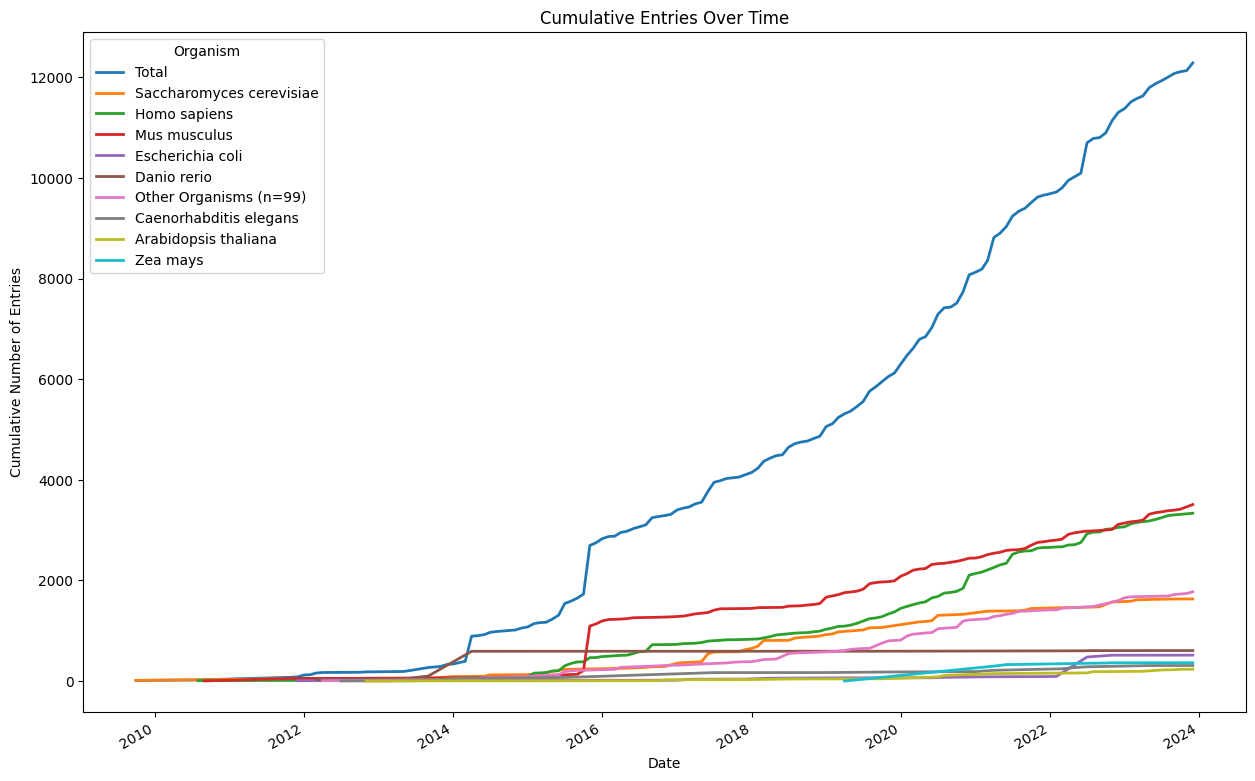

In [837]:

# plot cumulative plot of number of entries coloured by ScientificName
import matplotlib.pyplot as plt

accepted_organisms = df['ScientificName'].value_counts().head(8).index.tolist()

# organisms not in accepted_organisms 
not_accepted_organisms = [i for i in df['ScientificName'].unique() if i not in accepted_organisms]


df['ScientificName'] = df['ScientificName'].apply(lambda x: x if x in accepted_organisms else f'Other Organisms (n={len(not_accepted_organisms)})')

df = df.sort_values('Date')

# Create a new figure
fig, ax = plt.subplots(figsize=(15, 10))

# Ensure lines continue to current date if latest dataset is not up to date
latest_date = df['Date'].max()
organisms_to_fix = df[df['Date'] < latest_date]['ScientificName'].unique()
for organism in organisms_to_fix:
    df.loc[len(df)] = {
        'Date': latest_date,
        'ScientificName': organism,
        'Run': 0,
        'BioProject': 0,
        'MONTH': 0,
        'YEAR': 0
        }

global_cumsum_df = df.groupby(['Date']).size().cumsum()
global_cumsum_df.plot(ax=ax, linewidth=2, label="Total")

# Create a line plot for each organism
for organism in df['ScientificName'].unique():
    organism_df = df[df['ScientificName'] == organism]
    organism_cumsum_df = organism_df.groupby(['Date']).size().cumsum()
    organism_cumsum_df.plot(ax=ax, linewidth=2, label=organism)

# Customize the plot appearance
ax.set_title('Cumulative Entries Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Number of Entries')
ax.legend(title='Organism', loc='upper left')
plt.show()



In [838]:
organism_order = df['ScientificName'].value_counts().index
organism_order = organism_order.tolist()[::-1]


(<Figure size 1500x1000 with 1 Axes>,
 <Axes: title={'center': 'Cumulative Samples Over Time by Organism'}, xlabel='Date', ylabel='Cumulative\nNumber of Samples'>)

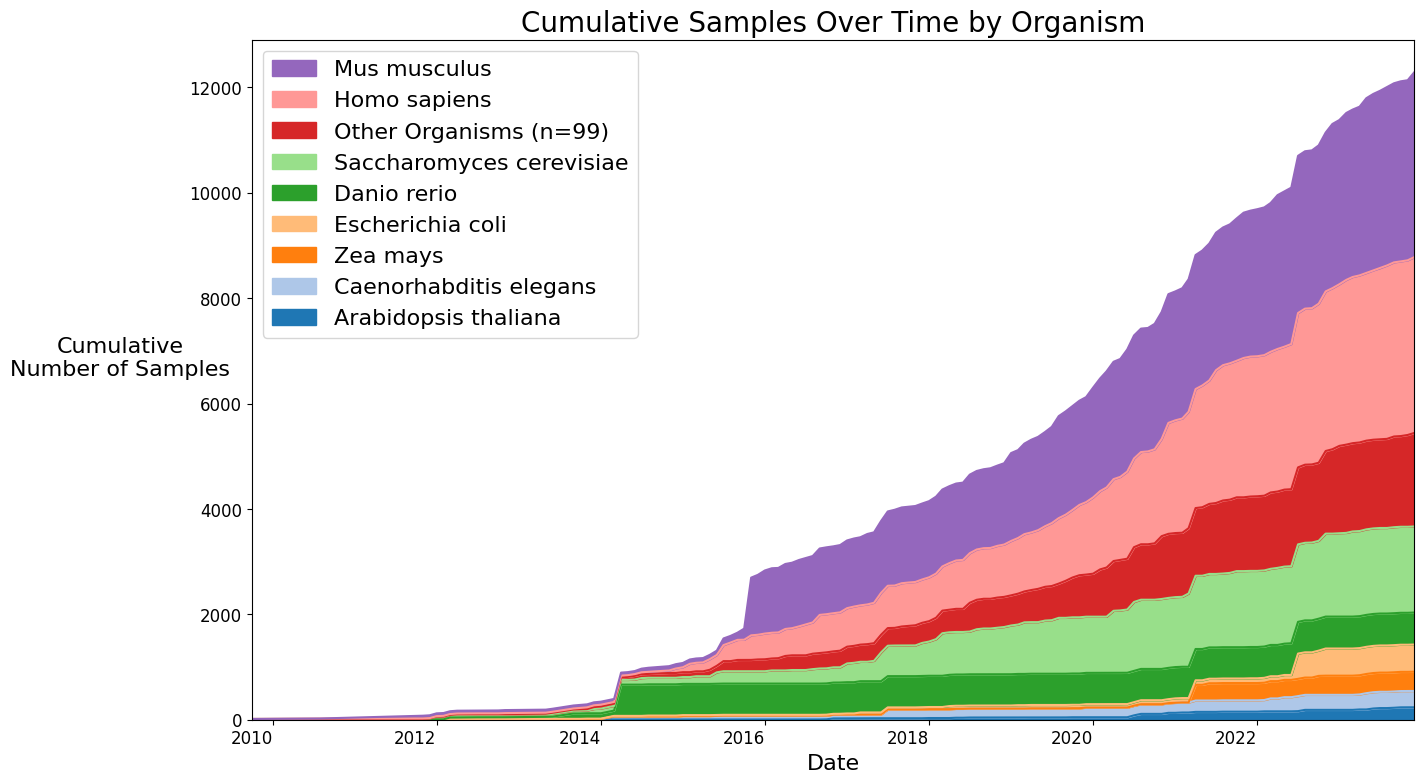

In [839]:


import matplotlib.pyplot as plt

def generate_cumulative_entries_plot(df, organism_order):
    # Group the dataframe by date and organism, calculate the size, unstack, fill NaN with 0, and cumulatively sum
    cumsum_df = df.groupby(['Date', 'ScientificName']).size().unstack().fillna(0).cumsum()
    
    # Reindex the columns based on the organism order
    cumsum_df = cumsum_df.reindex(organism_order, axis=1)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_prop_cycle(color=plt.cm.tab20.colors)

    # ax.plot(cumsum_df, linewidth=2, area=True)
    cumsum_df.plot.area(ax=ax, title='Cumulative Entries Over Time by Organism')

    # reverse the legend order
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), title=None, loc='upper left', fontsize=16)
    ax.set_title('Cumulative Samples Over Time by Organism', fontsize=20)
    ax.set_xlabel('Date', fontsize=16)
    ax.set_ylabel('Cumulative\nNumber of Samples', rotation=0, labelpad=50, fontsize=16, ha='center')

    latest_date = df['Date'].max()
    # cut plot at latest date
    ax.set_xlim([df['Date'].min(), latest_date])

    ax.xaxis.set_tick_params(rotation=0, labelsize=12)
    ax.yaxis.set_tick_params(rotation=0, labelsize=12)
    # Return the figure and axes objects
    return fig, ax

generate_cumulative_entries_plot(df, organism_order)

In [840]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

def generate_cumulative_entries_plot(df, organism_order):
    # Group the dataframe by date and organism, calculate the size, unstack, fill NaN with 0, and cumulatively sum
    cumsum_df = df.groupby(['Date', 'ScientificName']).size().unstack().fillna(0).cumsum()

    # Reindex the columns based on the organism order
    cumsum_df = cumsum_df.reindex(organism_order, axis=1)

    # Create a new figure with subplots
    fig = make_subplots(rows=1, cols=1)

    # Iterate over the organisms and add traces to the plot
    for organism in organism_order:
        fig.add_trace(go.Scatter(x=cumsum_df.index,
                                 y=cumsum_df[organism],
                                 mode='lines',
                                 name=organism,
                                 fill='tonexty'
                                 ), row=1, col=1)

    # Customize the layout
    fig.update_layout(
        title='Cumulative Samples Over Time by Organism',
        xaxis_title='Date',
        yaxis_title='Cumulative Number of Samples',
        # legend_title='Organism',
        legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1),
        height=600,
        width=1200
    )

    # Set the x-axis range to the date range in the data
    latest_date = df['Date'].max()
    fig.update_xaxes(range=[df['Date'].min(), latest_date])

    return fig

# Call the function with your dataframe and organism order
fig = generate_cumulative_entries_plot(df, organism_order)

# Display the plot
fig.show()

(<Figure size 1500x1000 with 1 Axes>,
 <Axes: title={'center': 'Number of Publications per Year'}, xlabel='Year', ylabel='Number of\nPublications'>)

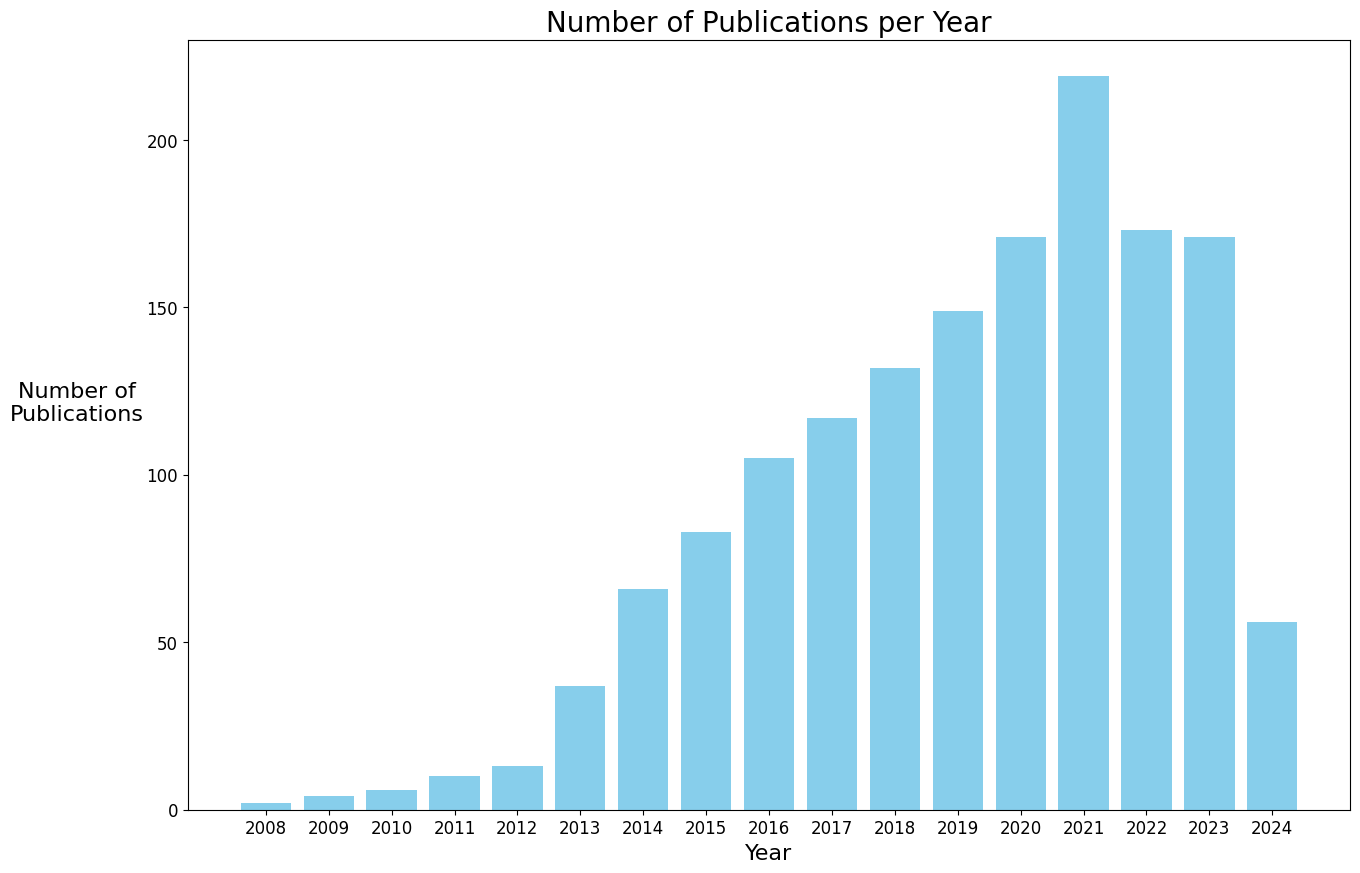

In [841]:
pubmed_df = pd.read_csv('data/pubmed_results.csv', dtype={'Year': int, 'count': int}, sep="\t")

# plot bar chart of number of publications per year
def plot_pubmed_results(pubmed_df):
    # Group the dataframe by year and calculate the number of publications

    # Create a bar plot
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.bar(pubmed_df['Year'], pubmed_df['Count'], color='skyblue')

    # Customize the plot appearance
    ax.set_title('Number of Publications per Year', fontsize=20)
    ax.set_xlabel('Year', fontsize=16)
    ax.set_ylabel('Number of\nPublications', fontsize=16, rotation=0, labelpad=50, ha='center')
    ax.xaxis.set_tick_params(rotation=0, labelsize=12)
    ax.yaxis.set_tick_params(rotation=0, labelsize=12)

    ax.set_xticks(pubmed_df['Year'])

    # Return the figure and axes objects
    return fig, ax

plot_pubmed_results(pubmed_df)

In [842]:
# make a combined plot of the two plots using plotly

import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_combined_pubmed_entries(df, pubmed_df, organism_order):
    fig, ax = generate_cumulative_entries_plot(df, organism_order)
    fig2, ax2 = plot_pubmed_results(pubmed_df)

    # Create a subplot with two plots
    fig = make_subplots(rows=2, cols=1, subplot_titles=("Cumulative Entries Over Time by Organism", "Number of Publications per Year"))

    # Add the first plot
    fig.add_trace(go.Scatter(x=fig.axes[0].get_xticks(), y=fig.axes[0].get_yticks(), mode='lines', name='Cumulative Entries Over Time by Organism'), row=1, col=1)

    # Add the second plot
    fig.add_trace(go.Bar(x=pubmed_df['Year'], y=pubmed_df['Count'], name='Number of Publications per Year'), row=2, col=1)

    # Update the layout
    fig.update_layout(height=800, width=1200, title_text="Combined Plot of Cumulative Entries and Publications")

    return fig

plot_combined_pubmed_entries(df, pubmed_df, organism_order)


ValueError: too many values to unpack (expected 2)

In [ ]:
# find number of Danio rerio entries per month
df_danio = df[df['ScientificName'] == 'Danio rerio']
df_danio = df_danio.groupby('Date')
df_danio = df_danio.size().reset_index(name='counts')
df_danio

,Date,counts
0,2012-03-01,34
1,2013-05-01,8
2,2013-09-01,59
3,2014-04-01,492
4,2019-10-01,1
5,2022-06-01,8
6,2022-08-01,4


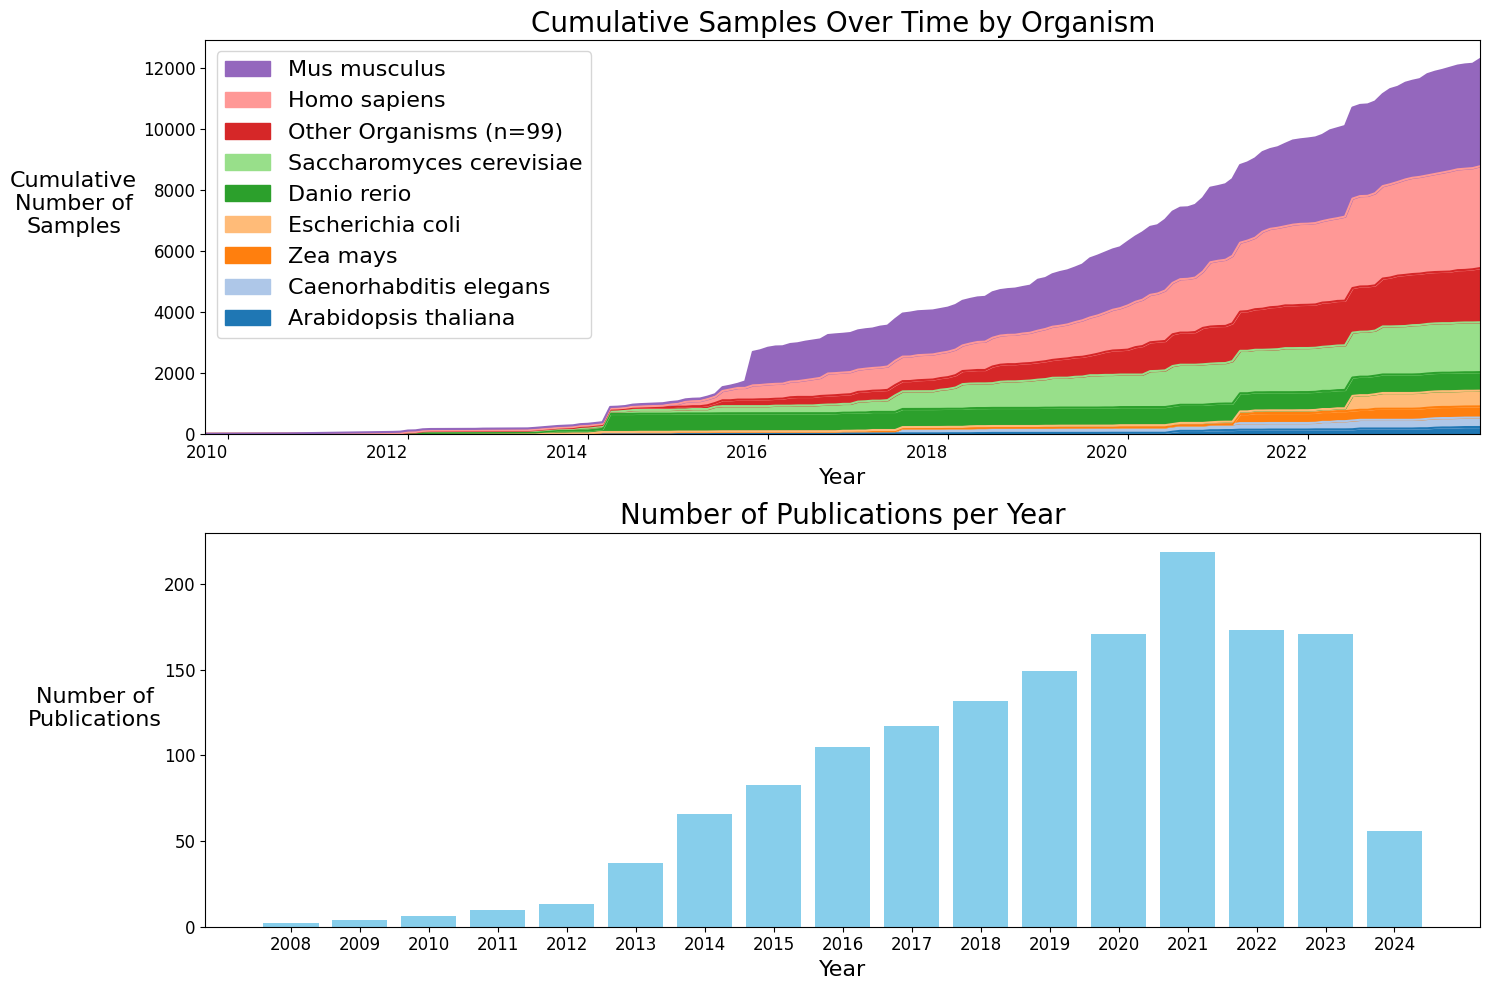

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(2, 1, figsize=(15, 10))


def generate_cumulative_entries_plot(df, organism_order, fig, ax):
    cumsum_df = df.groupby(['Date', 'ScientificName']).size().unstack().fillna(0).cumsum()
    cumsum_df = cumsum_df.reindex(organism_order, axis=1)

    ax.set_prop_cycle(color=plt.cm.tab20.colors)
    cumsum_df.plot.area(ax=ax, title='Cumulative Entries Over Time by Organism')

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), title=None, loc='upper left', fontsize=16)
    ax.set_title('Cumulative Samples Over Time by Organism', fontsize=20)
    ax.set_xlabel('Year', fontsize=16)
    ax.set_ylabel('Cumulative\nNumber of\nSamples', rotation=0, labelpad=50, fontsize=16, ha='center')

    latest_date = df['Date'].max()
    ax.set_xlim([df['Date'].min(), latest_date])
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_tick_params(rotation=0, labelsize=12)
    ax.yaxis.set_tick_params(rotation=0, labelsize=12)

    return fig, ax

def plot_pubmed_results(pubmed_df, ax):
    ax.bar(pubmed_df['Year'], pubmed_df['Count'], color='skyblue')

    ax.set_title('Number of Publications per Year', fontsize=20)
    ax.set_xlabel('Year', fontsize=16)
    ax.set_ylabel('Number of\nPublications', fontsize=16, rotation=0, labelpad=50, ha='center')
    ax.tick_params(axis='x', rotation=0, labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

    ax.set_xticks(pubmed_df['Year'])


# Create the two-panel figure
fig, ax1 = generate_cumulative_entries_plot(df, organism_order, fig, ax[0])

# Create the second axis for the bar plot
plot_pubmed_results(pubmed_df, ax[1])

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()